# Effect of Weather on F1 Fastest Lap Times & Speed

## Introduction

The objective of this project is to determine whether or not variables such as temperature, track temperature and humidity etc may effect track fastest lap speeds, times and total laps completed.

Data is analysed from five tracks over four different seasons, from 2016 to 2019.

* Silverstone, Britain
* Albert Park, Melbourne
* Interlagos, Brazil
* Catalunya, Spain
* De spa, Belgium

Table of contents:

Overview section
* Data Preparation
* Some other section
* Another section

## Data Preparation

### Preliminaries

In [190]:
# Module Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
import statsmodels.api as sm



In [5]:
# Helper functions
def to_milliseconds(string):
    string = string.replace(".", ":").split(":")
    minutes = int(string[0])
    seconds = int(string[1])
    milliseconds = int(string[2])
    return (minutes * 60000) + (seconds * 1000) + milliseconds

to_milliseconds("1:28.604")

88604

### Reading in Data & Cleaning

In [50]:
# Read invididual data files
races = pd.read_csv('https://raw.githubusercontent.com/floeck/formula-1-major-project/master/data/formula-1/races.csv', sep = ',')
results = pd.read_csv('../data/formula-1/results.csv', sep = ',')
track_weather = pd.read_csv('../data/weather/track_weather.csv', sep = ',')

# Drop unneccesary columns
races = races.drop(columns = ['year', 'circuitId', 'round', 'time', 'url'])
results = results.drop(columns = ['resultId', 'driverId', 'constructorId', 'number', 'grid', 'position',
                                  'positionText', 'positionOrder', 'points', 'laps', 'fastestLap', 'time',
                                  'milliseconds', 'fastestLap', 'rank'])

# Update problem data in columns & query only those with races finishes
results = results.replace(r'\\N','null', regex=True)
results = results.loc[results['fastestLapTime'] != 'null']
results = results.drop(columns = ['statusId'])
results['fastestLapSpeed'] = results['fastestLapSpeed'].astype(float)

# Convert fastest time to milliseconds
results['fastestLapTime'] = results['fastestLapTime'].apply(to_milliseconds)

# Group by race and track and average fastest lap and top speed for race
races_results = races.merge(results, on = 'raceId').groupby(['raceId', 'name', 'date']).mean()

df = races_results.merge(track_weather, on = 'date')

# Add rain column
rain_desc = ["rain", "shower", "drizzle", "wet"]
df['rain'] = np.where(df['weather'].str.contains('|'.join(rain_desc)), 'wet', 'dry')

#remove messy weather column (various titles for same meaning, inconclusive weather, e.g ('wet/dry','dry then wet' etc))
df = df.drop(columns=['weather'])

# Add year categorical column
df['year'] = df['date'].str[:4].astype(int).astype('category')

# Export dataframe to csv for submission
df.to_csv('../data/V10FTW_Data.csv')



# Debug query for specific years/tracks
#df = df.loc[~df['track'].str.contains('|'.join(tracks))]
#df = df.loc[df['date'].str.contains('|'.join(years))]

In [51]:
#results.sample(n = 12, random_state = 998)
results.head()

,raceId,fastestLapTime,fastestLapSpeed
0,18,87452,218.300
1,18,87739,217.586
2,18,88090,216.719
3,18,88603,215.464
4,18,87418,218.385


## Data Plots

### Basic Scatter Plots

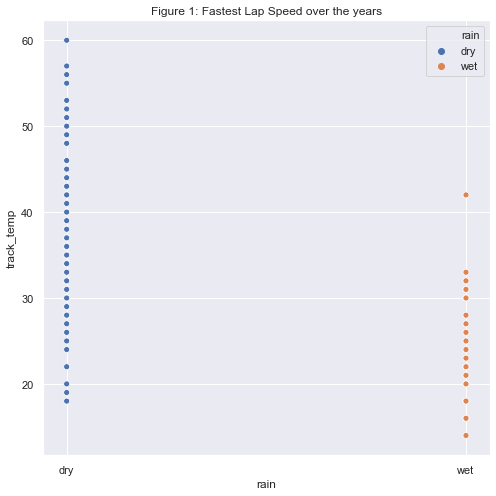

In [52]:
# create scatterplot 
sns.set(rc={'figure.figsize':(8,8)})

sns.scatterplot(df['rain'], df['track_temp'], hue=df['rain'])
plt.title('Figure 1: Fastest Lap Speed over the years')
plt.legend(bbox_to_anchor=(1,1))
plt.show();




In [53]:
# fit linear regression temp 	track_temp 	humidity 	air_pressure 	wind_speed 	wind_direction 	rain
X = df[['track_temp', 'wind_speed', 'year']]
Y = df['fastestLapTime']

# convert categorical into dummy/indicator variables
X = pd.get_dummies(data=X, drop_first=True)

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# prediction with sklearn

track_temp = 24
humidity = 80
air_pressure = 1000
wind_speed = 2
rain = 0
year = 2016
#print ('Predicted Fastest Lap Speed: \n', regr.predict([[track_temp, humidity, wind_speed, rain, year]]))

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
#predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 102659.3442220435
Coefficients: 
 [ -384.49162342   343.99589999 -3093.32541805  1865.27185668
  4877.40360358  2619.10797971  4302.91407992  2518.3315955
  6152.45561144  6009.4868061   4817.10532574  1611.73251339
   220.25973395   152.15232975]
                            OLS Regression Results                            
Dep. Variable:         fastestLapTime   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     3.059
Date:                Tue, 22 Sep 2020   Prob (F-statistic):           0.000261
Time:                        14:36:21   Log-Likelihood:                -2286.3
No. Observations:                 215   AIC:                             4603.
Df Residuals:                     200   BIC:                             4653.
Df Model:                          14                                         
Covariance Type:            

In [42]:
# Year not much of a predictor, 
# however, 2014 - 2015 (P < 0.1) statistically significant at the 10% level
# may indicate fastest lap times in 2014, 2015 were significantly higher than base year of 2007

<h2>Wet weather on different circuits:</h2>
<p>Comparing different tracks and the affect that wet vs dry weather has on the fastest lap times on each</p>

In [179]:
#No. of recorded races with with vs dry weather:
df['rain'].value_counts()

dry    182
wet     33
Name: rain, dtype: int64

In [180]:
#Compare dry vs wet laptimes at one circuit vs another
wet = df.loc[(df['rain'] == 'wet')]

#wet['track'].value_counts()  #view how many wet laptimes are recorded at each course

silverstone = df[df['track']=='silverstone']
sepang = df[df['track']=='sepang']
interlagos = df[df['track']=='interlagos']

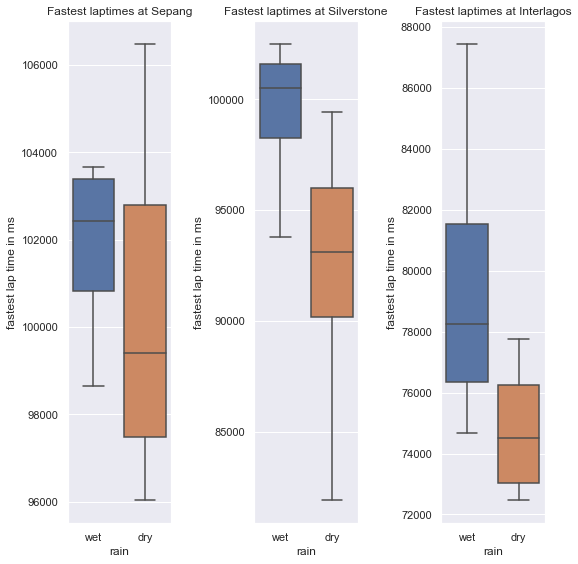

In [185]:
#Figure setup
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

#show sepang times
sepangTimes = sns.boxplot(y="fastestLapTime",x="rain",data=sepang.sort_values(by='rain',ascending=False),ax=ax1)
sepangTimes.set(ylabel="fastest lap time in ms",title="Fastest laptimes at Sepang")
#Show silverstone times
silverstoneTimes = sns.boxplot(y="fastestLapTime",x="rain",data=silverstone.sort_values(by='rain',ascending=False),ax=ax2)
silverstoneTimes.set(ylabel="fastest lap time in ms",title='Fastest laptimes at Silverstone')
#Show interlagos times
interlagosTimes = sns.boxplot(y="fastestLapTime",x="rain",data=interlagos.sort_values(by='rain',ascending=False),ax=ax3)
interlagosTimes.set(ylabel="fastest lap time in ms",title='Fastest laptimes at Interlagos')

plt.tight_layout()


In the above comparison, Sepang, Interlagos and Silverstone (3 of the tracks with the highest quantity of wet races, likely due to climates) show that wet lap times can have a general increase on laptimes (as expected). However, this also shows that there are some outliers and external factors other than rain that can affect these lengthier times. 
Those anomolies (on both wet and dry) are likely due to either severe weather or safety factors.
All of them do however show that it is incredibly unlikely to get the fastest possible laptime in wet conditions.